## Compute Sagnac Frequency - Spectra - Two Channel

## Imports

In [1]:
import os
import matplotlib.pyplot as plt

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read_inventory
from numpy import log10

from andbro__read_sds import __read_sds

from functions.get_fft import __get_fft

from matplotlib import rc
rc('text', usetex=True)


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [7]:
def __compute_psd(st0, twin_sec=60, spec="PSD"):

    from scipy.signal import welch
    from scipy.signal import get_window

    _st = st0.copy()

    _st.sort(keys=['channel'], reverse=True)

    nblock = int(st[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)
    win = get_window('hann', nblock, True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(_st):
        if spec.upper() == "PSD":
            ff, Pxx = welch(tr.data,
                            fs=tr.stats.sampling_rate,
                            window=win,
                            noverlap=overlap,
                            nfft=nblock,
                            scaling="density",
                            return_onesided=True)

        elif spec.upper() == "FFT":
            Pxx, ff, ph = __get_fft(tr.data, tr.stats.delta)

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

    out = {}
    out['Pxxs'] = Pxxs
    out['ffs'] = ffs
    out['chs'] = chs

    return out

## Configurations

In [4]:
config = {}


config['seeds'] = ["BW.DROMY..FJV", "BW.DROMY..FJW"]

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-10-23 23:30")
config['tend'] = UTCDateTime("2023-10-23 23:50")

## 10min with local signal
config['tbeg'] = UTCDateTime("2023-10-27 00:00")
config['tend'] = UTCDateTime("2023-10-27 00:10")

## 10min noise only
# config['tbeg'] = UTCDateTime("2023-10-27 16:45")
# config['tend'] = UTCDateTime("2023-10-27 16:55")

## only RV running (RZ transmitter off)
config['tbeg'] = UTCDateTime("2023-11-09 14:00")
config['tend'] = UTCDateTime("2023-11-09 14:10")

## RZ und RV transmitter on, MLTI on RZ
# config['tbeg'] = UTCDateTime("2023-11-09 16:00")
# config['tend'] = UTCDateTime("2023-11-09 16:10")

## RZ und RV transmitter on
# config['tbeg'] = UTCDateTime("2023-11-10 12:55")
# config['tend'] = UTCDateTime("2023-11-10 13:05")

## RV and RW comparable sine
config['tbeg'] = UTCDateTime("2023-11-17 00:00")
config['tend'] = UTCDateTime("2023-11-17 00:10")

## RV interference and RW off
config['tbeg'] = UTCDateTime("2024-04-19 00:00")
config['tend'] = UTCDateTime("2024-04-19 00:10")

## RV new excitation and RW off (with 50Ohm)
config['tbeg'] = UTCDateTime("2024-05-03 00:00")
config['tend'] = UTCDateTime("2024-05-03 00:10")


config['f_lower_zoomin'], config['f_upper_zoomin'] = 448-30, 448+30

config['datapath'] = data_path+"sagnac_frequency/prismspectra/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

## Load Raw data

In [8]:
def __load_romy_raw_data(seeds, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime

    st0 = Stream()

    for seed in seeds:

        print(f" -> loading {seed}...")

        try:
            st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
        except:
            print(f" -> failed for {seed}")

        st0 += st00

    st0 = st0.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

 -> loading BW.DROMY..FJV...
 -> loading BW.DROMY..FJW...


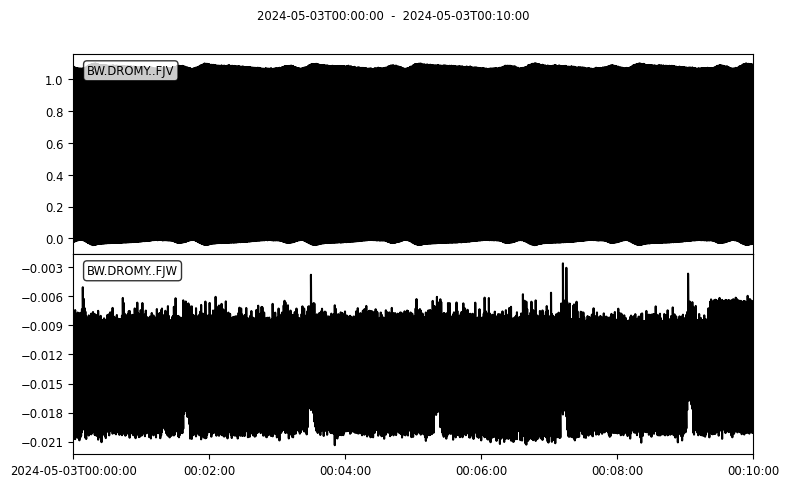

In [9]:
st = __load_romy_raw_data(config['seeds'], config['tbeg'], config['tend'], config['path_to_sds'])

# st.detrend("demean")

st.plot(equal_scale=False);

In [10]:
# st.select(channel="FJW").write("/home/andbro/Downloads/4Jan/westring_koester.csv", format="TSPAIR")
# st.select(channel="FJV").write("/home/andbro/Downloads/4Jan/westring_discrete.csv", format="TSPAIR")

In [11]:
def __makeplot_stream_PSD(st, twin_sec=60, f_lower_zoom=540, f_upper_zoom=560):

    from scipy import fftpack
    from numpy import abs
    from scipy.signal import welch, hann
    import matplotlib.pyplot as plt


    nblock = int(st[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)

    print(f" -> nseg = {nblock} | overlap = {overlap}")

    win = hann(nblock, True)


    fig, axes = plt.subplots(len(st),2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(st):

        # tr.data /= max(abs(tr.data))

        ff, Pxx = welch(tr.data,
                        fs=tr.stats.sampling_rate,
                        window=win, noverlap=overlap,
                        nfft=nblock,
                        scaling="spectrum",
                        return_onesided=True)

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times(),
                    tr.data,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].semilogy(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )

        axes[i,1].set_ylim(min(Pxx[10:]), max(Pxx[10:]))

        axes[i,0].set_ylabel(r'U (volt)')

        axes[i,1].set_ylabel(r'PSD (volt$^2$/Hz)')

        axes[i,0].legend(loc='upper left', framealpha=.8)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axes[i,1].set_xlim(f_lower_zoom, f_upper_zoom)
        # axes[i,1].set_ylim(top=0)

    plt.show();
    return fig, (Pxxs, ffs, chs)

 -> nseg = 300000 | overlap = 150000


/tmp/ipykernel_731184/992467483.py:14: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  win = hann(nblock, True)


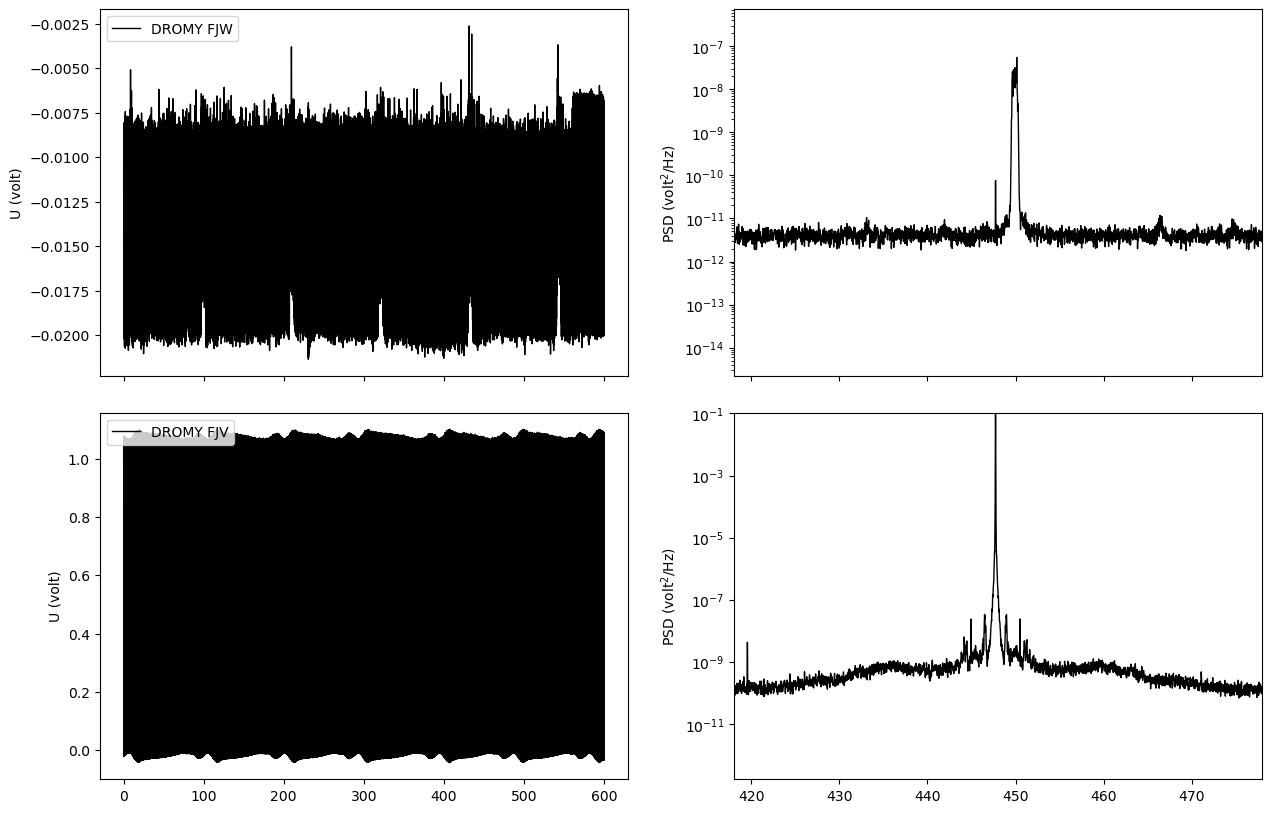

In [12]:
fig, out = __makeplot_stream_PSD(st, twin_sec=60, f_lower_zoom=config['f_lower_zoomin'], f_upper_zoom=config['f_upper_zoomin'])

# fig.savefig(config['path_to_figs']+f"Prismspectra_Westring_{st[0].stats.starttime.date}_trace&PSD.png", format="png", dpi=150, bbox_inches='tight')


## Plot Comparison

In [21]:
def __makeplot_psd_overview_with_zoomin(stx, twin_sec=60, plot_dB=True):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from numpy import log10

    font = 14

    stx = stx.detrend("demean")
    # stx = stx.normalize()

    out = __compute_psd(stx, twin_sec=twin_sec, spec="PSD")

    Pxxs, ffs, chs = out['Pxxs'], out['ffs'], out['chs']

    fig = plt.figure(figsize=(15, 8))

    plt.subplots_adjust(wspace=0.05)

    gs = GridSpec(1, 2, width_ratios=[2, 1])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    if plot_dB:
        max_db = []
        for jj in range(len(Pxxs)):
            max_db.append(max(10*log10(Pxxs[jj])))


    for jj in range(len(Pxxs)):
        if plot_dB:
            ax1.semilogx(ffs[jj], 10*log10(Pxxs[jj]) - max(max_db), alpha=0.5, label=chs[jj])
            ax2.plot(ffs[jj], 10*log10(Pxxs[jj]) - max(max_db), alpha=0.5, label=chs[jj])

        else:
            ax1.loglog(ffs[jj], Pxxs[jj], alpha=0.5, label=chs[jj])
            ax2.semilogy(ffs[jj], Pxxs[jj], alpha=0.5, label=chs[jj])

    # ax1.semilogx(ffs[2], 20*log10(Pxxs[2]), alpha=0.5, color="tab:green", label=chs[2], zorder=2)

    ax1.grid(alpha=0.2, which="both")
    ax1.set_xlabel("Frequency (Hz)", fontsize=font)
    ax1.set_ylabel(f"PSD (dB rel. to (1 $V^2$/Hz))", fontsize=font)
    ax1.legend(loc="upper center", fontsize=font-1, ncol=3)
    ax1.tick_params(labelsize=font-2)



    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    ax2.grid(alpha=0.2, which="both")
    ax2.tick_params(labelsize=font-2)
    ax2.set_yticklabels([])

    ax2.set_xlim(config['f_lower_zoomin'], config['f_upper_zoomin'])

    for ax in [ax1, ax2]:
        if plot_dB:
            ax.set_ylim(bottom=-120)
        else:
            ax.set_ylim(bottom=1e-15)

    ax1.text(.01, .99, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.01, .99, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    time_str = f"{str(stx[0].stats.starttime.time).split('.')[0]} - {str(stx[0].stats.endtime.time).split('.')[0]} UTC"
    ax1.set_title(f"{stx[0].stats.starttime.date} {time_str}")

    plt.show();
    return fig

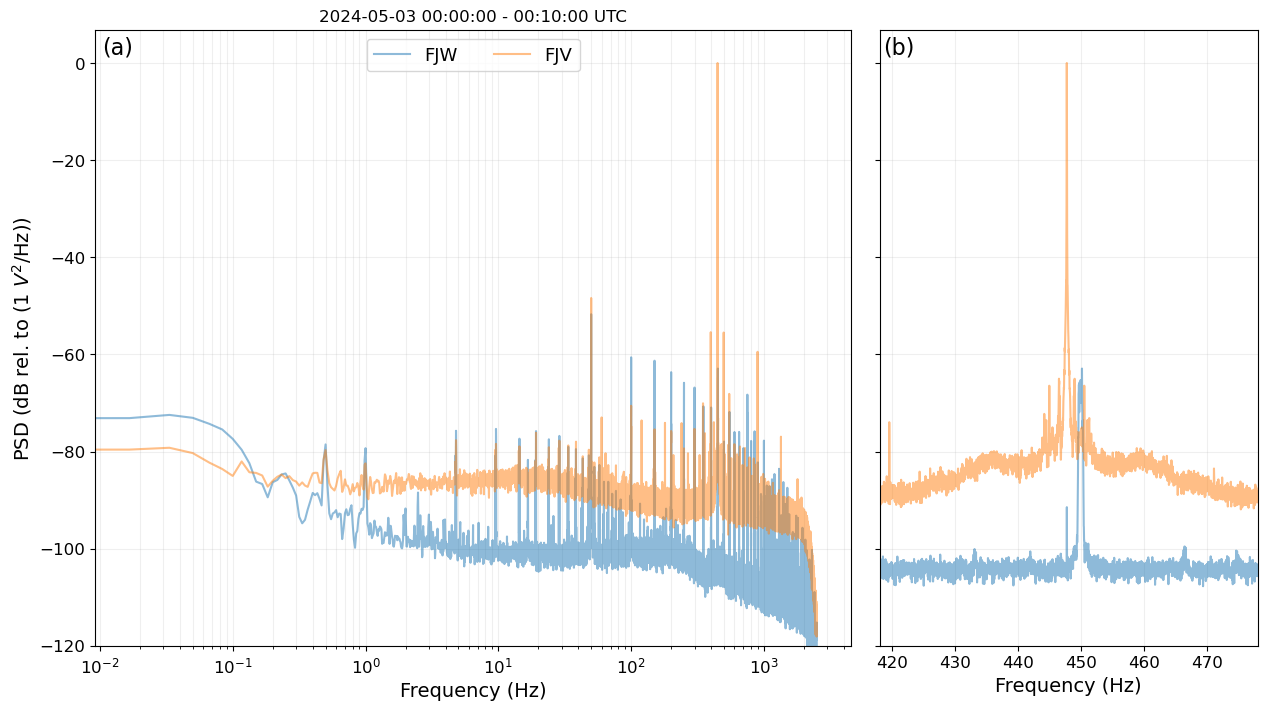

In [22]:
fig = __makeplot_psd_overview_with_zoomin(st, twin_sec=60, plot_dB=True)

# fig.savefig(config['path_to_figs']+f"Prismspectra_Westring_{st[0].stats.starttime.date}_zoomin.png", format="png", dpi=150, bbox_inches='tight')

fig.savefig(config['path_to_figs']+f"Westring_EastringOff_{st[0].stats.starttime.date}_zoomin.png", format="png", dpi=150, bbox_inches='tight')


In [27]:
romy = __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['tbeg'], config['tend'])

romy_inv = read_inventory(root_path+"Documents/ROMY/stationxml_ringlaser/dataless/dataless.seed.BW_ROMY")

romy = romy.remove_sensitivity(romy_inv)

romy = romy.detrend("demean")

if len(romy) > 1:
    romy.merge()

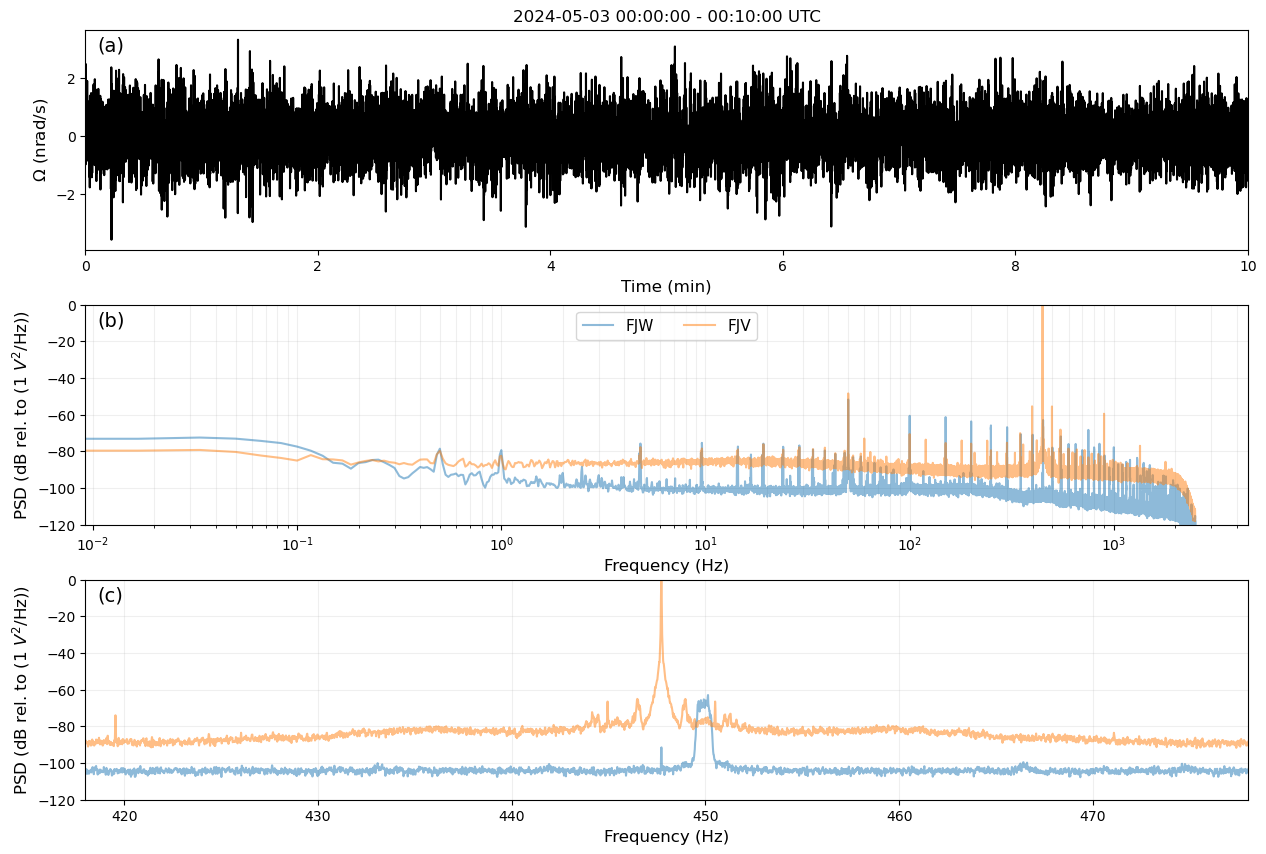

In [29]:
def __makeplot2(st0, stx, twin_sec=30, plot_dB=True):


    out = __compute_psd(stx, twin_sec=twin_sec)

    Pxxs, ffs, chs = out['Pxxs'], out['ffs'], out['chs']

    fig, ax = plt.subplots(3, 1, figsize=(15, 10))

    plt.subplots_adjust(hspace=0.25)

    font = 12

    ax[0].plot(st0[0].times()/60, st0[0].data*1e9, color="k")
    ax[0].set_xlim(0, max(st0[0].times()/60))
    ax[0].set_xlabel("Time (min)", fontsize=font)
    ax[0].set_ylabel("$\Omega$ (nrad/s)", fontsize=font)

    time_str = f"{str(stx[0].stats.starttime.time).split('.')[0]} - {str(stx[0].stats.endtime.time).split('.')[0]} UTC"
    ax[0].set_title(f"{stx[0].stats.starttime.date} {time_str}")

    if plot_dB:
        max_db = []
        for jj in range(len(Pxxs)):
            max_db.append(max(10*log10(Pxxs[jj])))

    for jj in range(len(Pxxs)):
        if plot_dB:
            ax[1].semilogx(ffs[jj], 10*log10(Pxxs[jj]) - max(max_db), alpha=0.5, label=chs[jj])
            ax[2].plot(ffs[jj], 10*log10(Pxxs[jj]) - max(max_db), alpha=0.5, label=chs[jj])
            ax[1].set_ylim(-120, 0)
            ax[2].set_ylim(-120, 0)
        else:
            ax[1].loglog(ffs[jj], Pxxs[jj], alpha=0.5, label=chs[jj])
            ax[2].semilogy(ffs[jj], Pxxs[jj], alpha=0.5, label=chs[jj])

    ax[1].grid(alpha=0.2, which="both")
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[1].set_ylabel(f"PSD (dB rel. to (1 $V^2$/Hz))", fontsize=font)
    ax[1].legend(loc="upper center", fontsize=font-1, ncol=3)
    ax[1].tick_params(labelsize=font-2)



    ax[2].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[2].grid(alpha=0.2, which="both")
    ax[2].tick_params(labelsize=font-2)
    ax[2].set_ylabel(f"PSD (dB rel. to (1 $V^2$/Hz))", fontsize=font)

    ax[2].set_xlim(config['f_lower_zoomin'], config['f_upper_zoomin'])

    ax[0].text(.01, .97, '(a)', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.01, .97, '(b)', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)
    ax[2].text(.01, .97, '(c)', ha='left', va='top', transform=ax[2].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot2(romy, st, twin_sec=60, plot_dB=True)

# fig.savefig(config['path_to_figs']+f"Prismspectra_Westring_{st[0].stats.starttime.date}_rotation_spectra.png", format="png", dpi=150, bbox_inches='tight')

fig.savefig(config['path_to_figs']+f"Westring_EastringOff_{st[0].stats.starttime.date}_rotation_spectra.png", format="png", dpi=150, bbox_inches='tight')
